In [1]:
from cadcad.spaces import space
from cadcad.dynamics import block
from cadcad.spaces import Bit, Real, Integer, EmptySpace
from cadcad.points import Point
from cadcad.systems import Experiment
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(Bit)

Space Bit has dimensions {'bit': 'bool'}


In this notebook i will make a discrete time variant of a homocidal chaufeur

In [3]:

@space
class CartesianPlane:
    x:float
    y:float

CartesianPlaneDot = CartesianPlane.rename_dims({'x':'dx', 'y':'dy'})

@space
class Particle:
    pos:CartesianPlane
    vel:CartesianPlaneDot
    # used to encode a constraint
    #but this is exactly the kind of thing
    #i would like to push into the model params
    maxspeed : float

#this block serves as a kind of constraint checker for Particle
#i would like to be able to assign this block to the Space Paricle
#as a builtin constraint
@block
def isValidParticle(domain:Point[Particle])-> Point[Bit]:
    input = deepcopy(domain)
    dx= input['vel']['dx']
    dy= input['vel']['dy']

    vmax = input['maxspeed']

    output = {'bit':bool(dx**2+dy**2<=vmax**2)}

    return Point(Bit, output)

@block
def projectValidParticle(domain:Point[Particle])-> Point[Particle]:
    input = deepcopy(domain)

    bit = isValidParticle(input)
    output = input
    if not(bit['bit']):
        dx= input['vel']['dx']
        dy= input['vel']['dy']
        magnitude = np.sqrt(dx**2+dy**2)
        output['vel']['dx'] = input['maxspeed']*dx/magnitude
        output['vel']['dy'] = input['maxspeed']*dy/magnitude
      
    return output


print(Particle)
Particle.unroll_schema()

Space Particle has dimensions {'pos': 'CartesianPlane', 'vel': 'CartesianPlane', 'maxspeed': 'float'}


{'pos': {'x': 'float', 'y': 'float'},
 'vel': {'dx': 'float', 'dy': 'float'},
 'maxspeed': 'float'}

In [4]:
Particle.dimensions()

{'pos': 'CartesianPlane', 'vel': 'CartesianPlane', 'maxspeed': 'float'}

In [5]:
CartesianPlaneDot.unroll_schema()

{'dx': 'float', 'dy': 'float'}

In [6]:
initAlice = Point(Particle, {'pos': {'x': 1.0, 'y': 1.0},
 'vel': {'dx': -.2, 'dy': .2}, 'maxspeed':.2})

In [7]:
print(initAlice)

Point in space Particle has data
{
    "pos": {
        "x": 1.0,
        "y": 1.0
    },
    "vel": {
        "dx": -0.2,
        "dy": 0.2
    },
    "maxspeed": 0.2
}



In [8]:
np.sqrt(.7071067811865475**2+.7071067811865475**2)


0.9999999999999999

In [9]:
print(isValidParticle(initAlice))

Point in space Bit has data
{
    "bit": false
}



In [10]:
print(projectValidParticle(initAlice))

Point in space Particle has data
{
    "pos": {
        "x": 1.0,
        "y": 1.0
    },
    "vel": {
        "dx": -0.1414213562373095,
        "dy": 0.1414213562373095
    },
    "maxspeed": 0.2
}



In [11]:
validInitAlice = deepcopy(projectValidParticle(initAlice))
#desirable UX
# validInitAlice = initAlice.apply(projectValidParticle)
print(validInitAlice)

Point in space Particle has data
{
    "pos": {
        "x": 1.0,
        "y": 1.0
    },
    "vel": {
        "dx": -0.1414213562373095,
        "dy": 0.1414213562373095
    },
    "maxspeed": 0.2
}



In [12]:
print(initAlice)

Point in space Particle has data
{
    "pos": {
        "x": 1.0,
        "y": 1.0
    },
    "vel": {
        "dx": -0.2,
        "dy": 0.2
    },
    "maxspeed": 0.2
}



In [13]:
Acc = CartesianPlane.rename_dims({'x':'ddx', 'y':'ddy'})
Acc.unroll_schema()

{'ddx': 'float', 'ddy': 'float'}

In [14]:
AliceUpdateDomain = (Particle * Acc).rename_dims({'cartesianplane':"acc"})
AliceUpdateDomain.unroll_schema()

{'particle': {'pos': {'x': 'float', 'y': 'float'},
  'vel': {'dx': 'float', 'dy': 'float'},
  'maxspeed': 'float'},
 'acc': {'ddx': 'float', 'ddy': 'float'}}

In [15]:
@block
def particleSubspace(domain: Point[AliceUpdateDomain])-> Point[Particle]:
    input = deepcopy(domain)
    return Point(Particle, input.data['particle'])

In [16]:

@block
def aliceUpdate(domain:Point[AliceUpdateDomain])-> Point[Particle]:
    input = deepcopy(domain)
    output = particleSubspace(input)

    output['pos']['x']  += input['particle']['vel']['dx']
    output['pos']['y']  += input['particle']['vel']['dy']

    output['vel']['dx']  += input['acc']['ddx']
    output['vel']['dy']  += input['acc']['ddy']

    output = projectValidParticle(output)

    return output
    

In [17]:
import json
def printPretty(nestedDict,sort_keys=True, indent=4):
    print(json.dumps(nestedDict,sort_keys=sort_keys, indent=indent))

In [18]:
alice_acc_data = {'acc':{'ddx':-.5, 'ddy':-.1 }}
alice_acc_data['particle'] = deepcopy(validInitAlice.data)
printPretty(AliceUpdateDomain.unroll_schema())

{
    "acc": {
        "ddx": "float",
        "ddy": "float"
    },
    "particle": {
        "maxspeed": "float",
        "pos": {
            "x": "float",
            "y": "float"
        },
        "vel": {
            "dx": "float",
            "dy": "float"
        }
    }
}


In [19]:
printPretty(alice_acc_data)

{
    "acc": {
        "ddx": -0.5,
        "ddy": -0.1
    },
    "particle": {
        "maxspeed": 0.2,
        "pos": {
            "x": 1.0,
            "y": 1.0
        },
        "vel": {
            "dx": -0.1414213562373095,
            "dy": 0.1414213562373095
        }
    }
}


In [20]:
alice_update_input = Point(AliceUpdateDomain, alice_acc_data)

In [21]:
print(alice_update_input)

Point in space Particle*CartesianPlane has data
{
    "acc": {
        "ddx": -0.5,
        "ddy": -0.1
    },
    "particle": {
        "pos": {
            "x": 1.0,
            "y": 1.0
        },
        "vel": {
            "dx": -0.1414213562373095,
            "dy": 0.1414213562373095
        },
        "maxspeed": 0.2
    }
}



In [22]:
alice_new = deepcopy(aliceUpdate(alice_update_input))
print(initAlice)

Point in space Particle has data
{
    "pos": {
        "x": 1.0,
        "y": 1.0
    },
    "vel": {
        "dx": -0.2,
        "dy": 0.2
    },
    "maxspeed": 0.2
}



In [23]:
print(validInitAlice)

Point in space Particle has data
{
    "pos": {
        "x": 1.0,
        "y": 1.0
    },
    "vel": {
        "dx": -0.1414213562373095,
        "dy": 0.1414213562373095
    },
    "maxspeed": 0.2
}



In [24]:
print(alice_new)

Point in space Particle has data
{
    "pos": {
        "x": 0.8585786437626906,
        "y": 1.1414213562373094
    },
    "vel": {
        "dx": -0.1995842750873474,
        "dy": 0.012888643755571487
    },
    "maxspeed": 0.2
}



In [25]:
Acc.unroll_schema()

{'ddx': 'float', 'ddy': 'float'}

In [26]:
@block
def randomWalk(domain:Point[EmptySpace])-> Point[Acc]:
    data = {}
    data['ddx'] = .005+np.random.randn()/5.0
    data['ddy'] = .005+np.random.randn()/5.0

    return Point(Acc, data)

In [27]:
emptyPoint = Point(EmptySpace,{})

In [28]:
sample_acc = randomWalk(emptyPoint)

In [29]:
print(sample_acc)

Point in space CartesianPlane has data
{
    "ddx": -0.24103795785392063,
    "ddy": -0.28763108900799916
}



In [30]:
initAlice.data

{'pos': {'x': 1.0, 'y': 1.0}, 'vel': {'dx': -0.2, 'dy': 0.2}, 'maxspeed': 0.2}

In [31]:
@block
def aliceDynamics(domain:Point[Particle])->Point[Particle]:
    alice = deepcopy(domain)
    acc = randomWalk(emptyPoint)
    
    arg_data = {}
    arg_data['particle'] = alice.data
    arg_data['acc'] = acc.data

    args = Point(AliceUpdateDomain, arg_data)

    output = aliceUpdate(args)

    return output

In [32]:
print(aliceDynamics(validInitAlice))

Point in space Particle has data
{
    "pos": {
        "x": 0.8585786437626906,
        "y": 1.1414213562373094
    },
    "vel": {
        "dx": -0.17460120950641203,
        "dy": -0.06954713169910895
    },
    "maxspeed": 0.2
}



In [33]:
experiment_params = {"iteration_n": 1, "steps": 25}

In [34]:
my_experiment = Experiment(validInitAlice, experiment_params, (aliceDynamics,))

results = my_experiment.run()

In [35]:
d = results[0].data
n = len(d)
r = np.zeros((n,4))
print(d)

[<cadcad.points.Point object at 0x7fad9054f970>, <cadcad.points.Point object at 0x7fad9054ceb0>, <cadcad.points.Point object at 0x7fad9054e170>, <cadcad.points.Point object at 0x7fad9054d750>, <cadcad.points.Point object at 0x7fad9054f8e0>, <cadcad.points.Point object at 0x7fad9054f4f0>, <cadcad.points.Point object at 0x7fad9054fe20>, <cadcad.points.Point object at 0x7fad9054d450>, <cadcad.points.Point object at 0x7fad9054e5f0>, <cadcad.points.Point object at 0x7fad9054e6b0>, <cadcad.points.Point object at 0x7fad9054cd90>, <cadcad.points.Point object at 0x7fad9054f460>, <cadcad.points.Point object at 0x7fad9054f0d0>, <cadcad.points.Point object at 0x7fad9054e2f0>, <cadcad.points.Point object at 0x7fad9054e0b0>, <cadcad.points.Point object at 0x7fad9054d3f0>, <cadcad.points.Point object at 0x7fad9054f4c0>, <cadcad.points.Point object at 0x7fad80154670>, <cadcad.points.Point object at 0x7fad80154c10>, <cadcad.points.Point object at 0x7fad80154700>, <cadcad.points.Point object at 0x7fad80

In [36]:
for i in range(n):
    print(d[i])
    r[i,:]= [d[i]['pos']['x'], d[i]['pos']['y'],d[i]['vel']['dx'], d[i]['vel']['dy']]

df = pd.DataFrame(r, columns=['x','y','dx','dy'])

Point in space Particle has data
{
    "pos": {
        "x": 0.8585786437626906,
        "y": 1.1414213562373094
    },
    "vel": {
        "dx": 0.024616698469234533,
        "dy": 0.1374655966446737
    },
    "maxspeed": 0.2
}

Point in space Particle has data
{
    "pos": {
        "x": 0.8831953422319251,
        "y": 1.278886952881983
    },
    "vel": {
        "dx": 0.048579656538017865,
        "dy": 0.1152205157025548
    },
    "maxspeed": 0.2
}

Point in space Particle has data
{
    "pos": {
        "x": 0.931774998769943,
        "y": 1.3941074685845378
    },
    "vel": {
        "dx": 0.1980897836816475,
        "dy": -0.027576033089588847
    },
    "maxspeed": 0.2
}

Point in space Particle has data
{
    "pos": {
        "x": 1.1298647824515904,
        "y": 1.366531435494949
    },
    "vel": {
        "dx": 0.05598468535738016,
        "dy": 0.005709685556344882
    },
    "maxspeed": 0.2
}

Point in space Particle has data
{
    "pos": {
        "x": 1.1858494678

In [37]:
df.head()

,x,y,dx,dy
0,0.858579,1.141421,0.024617,0.137466
1,0.883195,1.278887,0.048580,0.115221
2,0.931775,1.394107,0.198090,-0.027576
3,1.129865,1.366531,0.055985,0.005710
4,1.185849,1.372241,0.134296,-0.140422


<AxesSubplot:>

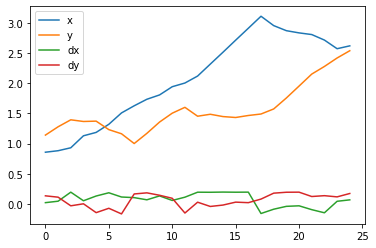

In [38]:
df.plot()

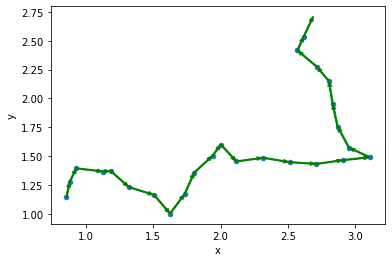

In [39]:
df.plot(x="x", y='y',kind="scatter")
for i in range(n):
    plt.arrow(*r[i], width = 0.01, color="green", length_includes_head=True)

In [40]:
@block
def getSpeed(domain:Point[Particle])->Point[Real]:
    input = deepcopy(domain).data
    output = np.sqrt(input['vel']['dx']**2+input['vel']['dy']**2)
    print(output)
    return Point(Real, {'real':output})

In [41]:
speeds = [getSpeed(pt) for pt in d]

0.13965232581092712
0.12504299367863222
0.2
0.056275087771741325
0.1943033165152418
0.19999999999999998
0.20000000000000004
0.2
0.20000000000000004
0.19999999999999998
0.11443342124819175
0.1866117856694003
0.2
0.19999999999999998
0.19999999999999998
0.2
0.2
0.1760155792935275
0.2
0.20000000000000004
0.2
0.15563806441463865
0.2
0.12915046993843735
0.18980571379045547


---
Breakpoint for Alice sim. Barlin is working on a Bob peice

In [42]:
@space
class PolarPlane:
    r:float
    theta:float

PolarPlaneDot = PolarPlane.rename_dims({'r':'dr', 'theta':'dtheta'})

@space
class Unicycle:
    pos: PolarPlane
    vel: PolarPlaneDot

print(Unicycle)
Unicycle.unroll_schema()

Space Unicycle has dimensions {'pos': 'PolarPlane', 'vel': 'PolarPlane'}


{'pos': {'r': 'float', 'theta': 'float'},
 'vel': {'dr': 'float', 'dtheta': 'float'}}

In [43]:
PolarPlaneDot.unroll_schema()

{'dr': 'float', 'dtheta': 'float'}

In [44]:
@space
class GameState:
    alice: Particle
    bob: Unicycle

@space
class NormalizedGameState:
    alice: Particle
    bob: Particle

print(GameState)
GameState.unroll_schema()

Space GameState has dimensions {'alice': 'Particle', 'bob': 'Unicycle'}


{'alice': {'pos': {'x': 'float', 'y': 'float'},
  'vel': {'dx': 'float', 'dy': 'float'},
  'maxspeed': 'float'},
 'bob': {'pos': {'r': 'float', 'theta': 'float'},
  'vel': {'dr': 'float', 'dtheta': 'float'}}}

In [45]:


initBob = Point(Unicycle, {'pos': {'r': 1.0, 'theta': np.pi/4},
 'vel': {'dr': 1.0, 'dtheta': np.pi/8}})

init = Point(GameState, {'alice':initAlice.data, 'bob':initBob.data})

In [46]:
print(init)

Point in space GameState has data
{
    "alice": {
        "pos": {
            "x": 1.0,
            "y": 1.0
        },
        "vel": {
            "dx": -0.2,
            "dy": 0.2
        },
        "maxspeed": 0.2
    },
    "bob": {
        "pos": {
            "r": 1.0,
            "theta": 0.7853981633974483
        },
        "vel": {
            "dr": 1.0,
            "dtheta": 0.39269908169872414
        }
    }
}



Alice is a Particle Trying to Evade the Unicycle Bob so she will attempt to maximize her distance from Bob in the Next timesteo

In [47]:
PolarPlaneDot.unroll_schema()

{'dr': 'float', 'dtheta': 'float'}

In [48]:
PolarPlane.unroll_schema()

{'r': 'float', 'theta': 'float'}

In [49]:
@block
def awkwardConverter1(domain:Point[PolarPlaneDot])->Point[PolarPlane]:
    """"""
    input = domain
    output = {}
    output['r'] = input['dr']
    output['theta'] = input['dtheta']

    return Point(PolarPlane, output)
    
@block
def awkwardConverter2(domain:Point[CartesianPlane])->Point[CartesianPlaneDot]:
    """needs """
    input = domain
    output = {}
    output['dx'] = input['x']
    output['dy'] = input['y']

    return Point(CartesianPlaneDot, output)

In [50]:
@block
def polar2cartesian(domain: Point[PolarPlane]) -> Point[CartesianPlane]:
    
    r = domain["r"]
    theta = domain["theta"]

    x = r*np.cos(theta)
    y = r*np.sin(theta)

    output = {"x":x, "y":y}

    return Point(CartesianPlane, output)

@block
def cartesian2polar(domain: Point[CartesianPlane]) -> Point[PolarPlane]:
    
    x = domain["x"]
    y = domain["y"]

    r = np.sqrt(x**2+y**2)
    if x==0:
        theta = np.sign(y)*np.pi/2
    else:
        theta = np.arctan(y/x)

    output = {"r":r, "theta":theta}

    return Point(PolarPlane, output)

@block
def normalize(domain:Point[GameState])->Point[NormalizedGameState]:
    #this is a piped block by hand
    #desired UX is to just write piping logic
    input=domain
    aliceData = input['alice']

    bobPosPolarPt = Point(PolarPlane, input['bob']['pos'])
    bobVelPolarDotPt = Point(PolarPlaneDot, input['bob']['vel'])
    print(bobVelPolarDotPt)
    bobVelPolarPt = awkwardConverter1(bobVelPolarDotPt)
    print(bobPosPolarPt)

    bobPosCartesian = polar2cartesian(bobPosPolarPt)

    bobVelCartesianTemp = polar2cartesian(bobVelPolarPt)
    print(bobVelCartesianTemp)

    bobVelCartesian=awkwardConverter2(bobVelCartesianTemp)
    print(bobVelCartesian)

    bobData = {'pos': bobPosCartesian.data, 'vel': bobVelCartesian.data}

    output = Point(NormalizedGameState, {'alice':aliceData, 'bob':bobData})

    return output



In [51]:
normalizedInit = normalize(init)

Point in space PolarPlane has data
{
    "dr": 1.0,
    "dtheta": 0.39269908169872414
}

Point in space PolarPlane has data
{
    "r": 1.0,
    "theta": 0.7853981633974483
}

Point in space CartesianPlane has data
{
    "x": 0.9238795325112867,
    "y": 0.3826834323650898
}

Point in space CartesianPlane has data
{
    "dx": 0.9238795325112867,
    "dy": 0.3826834323650898
}



ValueError: zip() argument 2 is shorter than argument 1

In [ ]:
print(init)

Point in space GameState has data
{
    "alice": {
        "pos": {
            "x": 1.0,
            "y": 1.0
        },
        "vel": {
            "dx": -0.2,
            "dy": 0.2
        }
    },
    "bob": {
        "pos": {
            "r": 1.0,
            "theta": 0.7853981633974483
        },
        "vel": {
            "dr": 1.0,
            "dtheta": 0.39269908169872414
        }
    }
}



In [ ]:
print(normalizedInit)

Point in space NormalizedGameState has data
{
    "alice": {
        "pos": {
            "x": 1.0,
            "y": 1.0
        },
        "vel": {
            "dx": -0.2,
            "dy": 0.2
        }
    },
    "bob": {
        "pos": {
            "x": 0.7071067811865476,
            "y": 0.7071067811865475
        },
        "vel": {
            "dx": 0.9238795325112867,
            "dy": 0.3826834323650898
        }
    }
}



In [ ]:
bobpos = [normalizedInit["bob"]["pos"]["x"], normalizedInit["bob"]["pos"]["y"]]
bobvelarrow = [normalizedInit["bob"]["pos"]["x"], 
                normalizedInit["bob"]["pos"]["y"], 
                normalizedInit["bob"]["vel"]["dx"],
                normalizedInit["bob"]["vel"]["dy"]]

alicepos = [normalizedInit["alice"]["pos"]["x"], normalizedInit["alice"]["pos"]["y"]]
alicevelarrow = [normalizedInit["alice"]["pos"]["x"], 
                normalizedInit["alice"]["pos"]["y"], 
                normalizedInit["alice"]["vel"]["dx"],
                normalizedInit["alice"]["vel"]["dy"]]


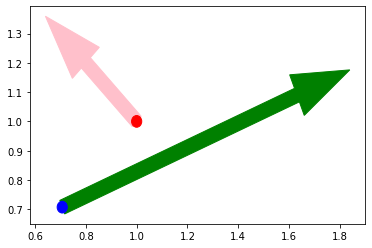

In [ ]:
from curses import color_content
import matplotlib.pyplot as plt
import matplotlib.patches as patches

normalizedInit["bob"]["pos"]["x"]
 
# Adding an arrow to graph starting
# from the base (2, 4) and with the
# length of 2 units from both x and y
# And setting the width of arrow for
# better visualization

plt.arrow(*alicevelarrow, width = 0.05, color="pink")
plt.arrow(*bobvelarrow, width = 0.05, color="green")
a = plt.Circle(alicepos, radius=.02, color="red")
b = plt.Circle(bobpos, radius=.02, color="blue")
plt.gca().add_patch(a)
plt.gca().add_patch(b)



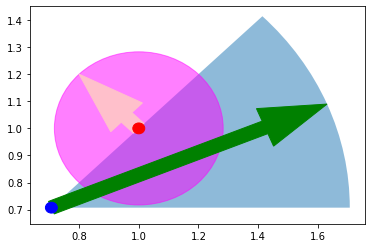

In [ ]:
bob_max_angle = np.pi/8
bob_max_speed = 1
alice_max_speed = np.sqrt(.2**2 + .2**2)

w = patches.Wedge(bobpos, bob_max_speed, (init["bob"]["vel"]["dtheta"]-bob_max_angle)*180/np.pi, (init["bob"]["vel"]["dtheta"]+bob_max_angle)*180/np.pi, alpha=.5)
plt.gca().add_patch(w)
c = plt.Circle(alicepos, radius=alice_max_speed, color="magenta", alpha=.5)
plt.gca().add_patch(c)
plt.arrow(*alicevelarrow, width = 0.05, color="pink", length_includes_head=True)
plt.arrow(*bobvelarrow, width = 0.05, color="green", length_includes_head=True)
a = plt.Circle(alicepos, radius=.02, color="red")
b = plt.Circle(bobpos, radius=.02, color="blue")
plt.gca().add_patch(a)
plt.gca().add_patch(b)


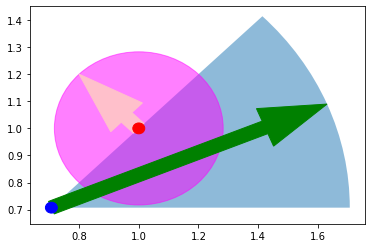

In [ ]:
bob_max_angle = np.pi/8
bob_max_speed = 1
alice_max_speed = np.sqrt(.2**2 + .2**2)

w = patches.Wedge(bobpos, bob_max_speed, (init["bob"]["vel"]["dtheta"]-bob_max_angle)*180/np.pi, (init["bob"]["vel"]["dtheta"]+bob_max_angle)*180/np.pi, alpha=.5)
plt.gca().add_patch(w)
c = plt.Circle(alicepos, radius=alice_max_speed, color="magenta", alpha=.5)
plt.gca().add_patch(c)
plt.arrow(*alicevelarrow, width = 0.05, color="pink", length_includes_head=True)
plt.arrow(*bobvelarrow, width = 0.05, color="green", length_includes_head=True)
a = plt.Circle(alicepos, radius=.02, color="red")
b = plt.Circle(bobpos, radius=.02, color="blue")
plt.gca().add_patch(a)
plt.gca().add_patch(b)